In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import warnings
import re
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# Importando os dados

In [2]:
NY_df = pd.read_csv(r'C:\Users\Administrator\Desktop\PROJETOS_GITHUB\Indicium_Lighthouse\teste_indicium_precificacao.csv')

In [3]:
# Eliminando o anúncio com id igual a 2595 para não contaminar o treinamento
# com dados que serão posteriormente utilizados para validar o modelo

NY_df = NY_df[~(NY_df["id"] == 2595)]

# Analisando as colunas do dataframe em relação a quantidade de valores nulos e zeros

In [4]:
null_counts = NY_df.isnull().sum()
null_counts

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

In [5]:
zero_counts = (NY_df == 0).sum()
zero_counts

id                                   0
nome                                 0
host_id                              0
host_name                            0
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                               11
minimo_noites                        0
numero_de_reviews                10052
ultima_review                        0
reviews_por_mes                      0
calculado_host_listings_count        0
disponibilidade_365              17533
dtype: int64

As colunas com informações de review ('numero_de_review', 'ultima_review', 'reviews_por_mes') e a coluna 'disponibilidade_365' possuem uma quantidade siginificativa de dados nulos ou zeros.

# Tratando os dados

In [6]:
# Eliminar linhas sem preço
NY_df.dropna(subset=['price'], inplace=True)

# Preencher valores ausentes com a data fixa "02-02-02" para saber que se trata de valor preenchido
NY_df['ultima_review'].fillna(pd.to_datetime("2002-02-02"), inplace=True)

# Substituir valores nulos
NY_df['reviews_por_mes'].fillna(0, inplace=True)

# Verificar se as alterações foram aplicadas corretamente
NY_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48893 entries, 1 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48893 non-null  int64  
 1   nome                           48877 non-null  object 
 2   host_id                        48893 non-null  int64  
 3   host_name                      48872 non-null  object 
 4   bairro_group                   48893 non-null  object 
 5   bairro                         48893 non-null  object 
 6   latitude                       48893 non-null  float64
 7   longitude                      48893 non-null  float64
 8   room_type                      48893 non-null  object 
 9   price                          48893 non-null  int64  
 10  minimo_noites                  48893 non-null  int64  
 11  numero_de_reviews              48893 non-null  int64  
 12  ultima_review                  48893 non-null  obje

# Matriz de correlação para as variáveis numéricas.

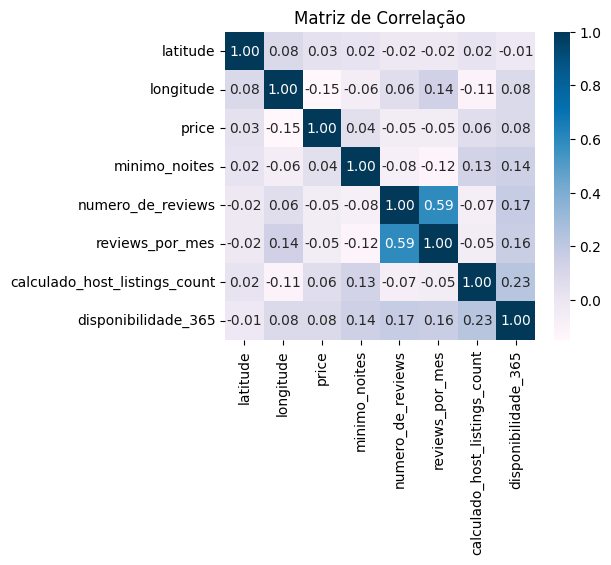

In [7]:
# Selecionando colunas de interesse
colunas = ['latitude', 'longitude', 'price', 'minimo_noites',
       'numero_de_reviews', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365']

# Calculando a matriz de correlação
matriz_correlacao = NY_df[colunas].corr()

# Plotando a matriz de correlação
plt.figure(figsize=(5, 4))
sns.heatmap(matriz_correlacao, annot=True, cmap='PuBu', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()


Nenhuma correlação linear significativa com o preço.

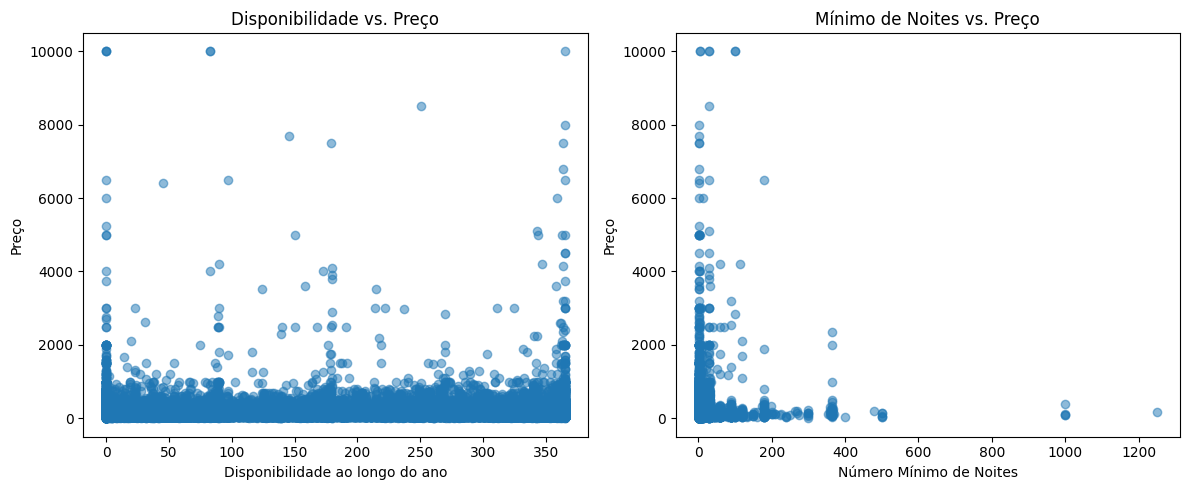

In [8]:
plt.figure(figsize=(12, 5))

# Plotando a relação entre a disponibilidade e o preço
plt.subplot(1, 2, 1)
plt.scatter(NY_df['disponibilidade_365'], NY_df['price'], alpha=0.5)
plt.title('Disponibilidade vs. Preço')
plt.xlabel('Disponibilidade ao longo do ano')
plt.ylabel('Preço')

# Plotando a relação entre o número mínimo de noites e o preço
plt.subplot(1, 2, 2)
plt.scatter(NY_df['minimo_noites'], NY_df['price'], alpha=0.5)
plt.title('Mínimo de Noites vs. Preço')
plt.xlabel('Número Mínimo de Noites')
plt.ylabel('Preço')

plt.tight_layout()
plt.show()



Analisando as variáveis "room_type" e "bairro_group"

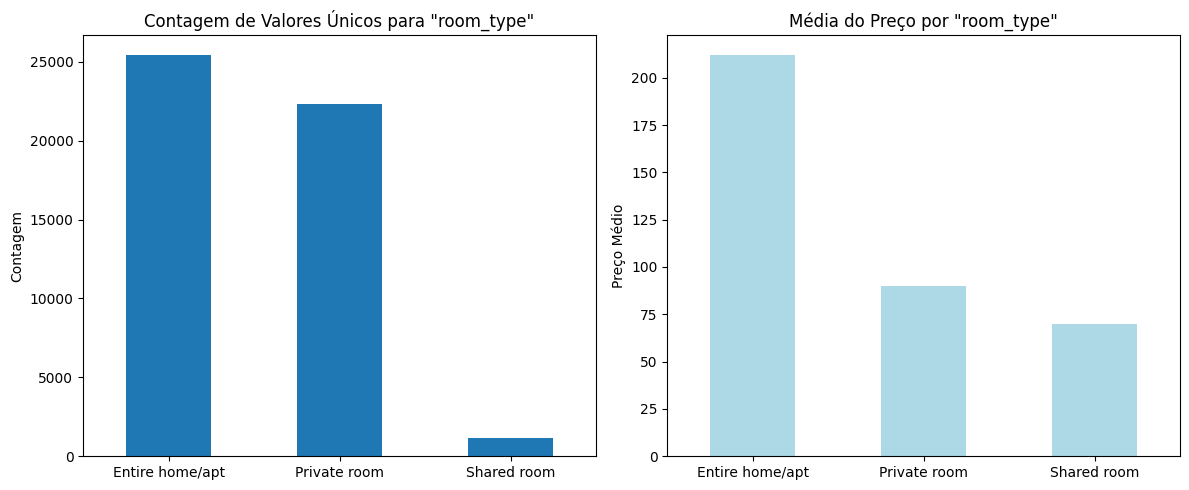

In [9]:
unique_counts = NY_df['room_type'].value_counts()

# Calculando a média do preço para cada tipo de 'room_type'
average_price_per_room_type = NY_df.groupby('room_type')['price'].mean()

# Criando o plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) 
unique_counts.plot(kind='bar')
plt.title('Contagem de Valores Únicos para "room_type"')
plt.ylabel('Contagem')
plt.xlabel('') 

plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
average_price_per_room_type.plot(kind='bar', color='#ADD8E6')
plt.title('Média do Preço por "room_type"')
plt.ylabel('Preço Médio')
plt.xlabel('') 

plt.xticks(rotation=0)

plt.tight_layout() 
plt.show()

Existe uma relação clara entre o tipo de acomodação e o preço.

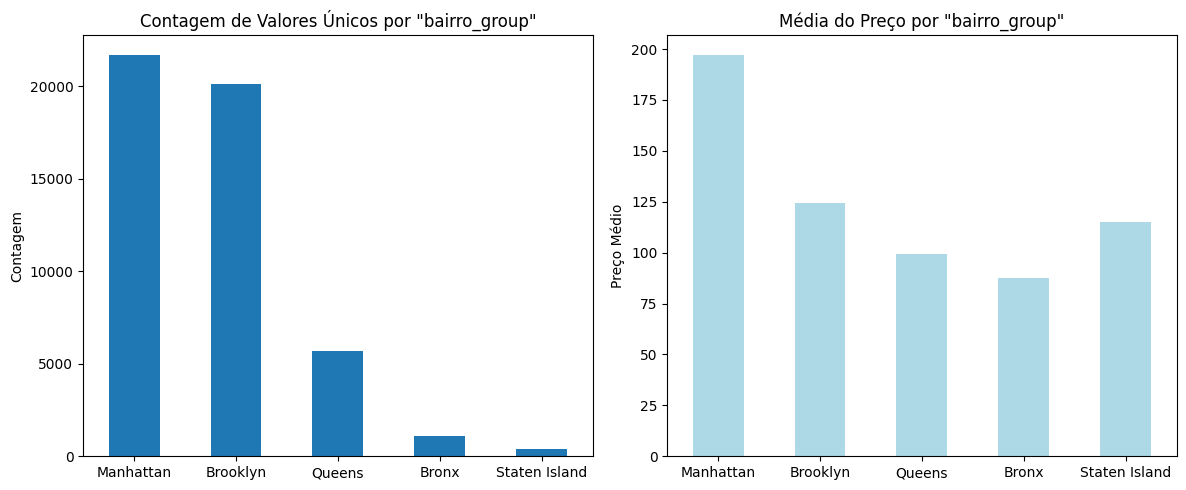

In [10]:
# Definindo a ordem das colunas no plot
order = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

# Contagem de valores únicos para 'bairro_group'
unique_counts_bairro = NY_df['bairro_group'].value_counts()

# Calculando a média do preço para cada 'bairro_group'
average_price_per_bairro_group = NY_df.groupby('bairro_group')['price'].mean()

# Ordenando os valores de acordo com a ordem específica desejada
average_price_per_bairro_group = average_price_per_bairro_group.reindex(order)

# Criando o plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
unique_counts_bairro.plot(kind='bar')
plt.title('Contagem de Valores Únicos por "bairro_group"')
plt.ylabel('Contagem')
plt.xticks(rotation=0)
plt.xlabel('') 

plt.subplot(1, 2, 2)
average_price_per_bairro_group.plot(kind='bar', color='#ADD8E6')
plt.title('Média do Preço por "bairro_group"')
plt.ylabel('Preço Médio')
plt.xticks(rotation=0)
plt.xlabel('') 

plt.tight_layout() 
plt.show()



Analisando as variáveis longitude e latitude

<Figure size 500x500 with 0 Axes>

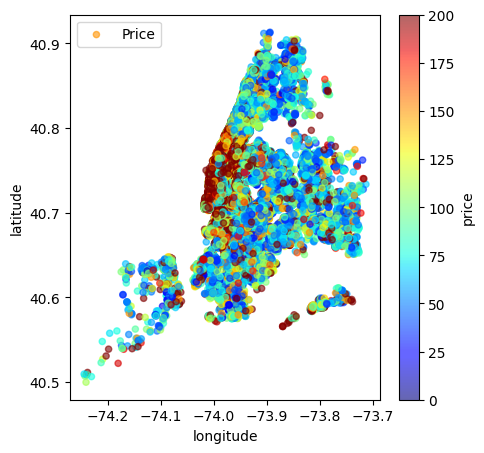

In [11]:
vmin = 0
vmax = 200

plt.figure(figsize=(5,5))
scatter_plot = NY_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.6,
           label="Price", figsize=(5,5),
           c="price", cmap=plt.get_cmap("jet"), 
           colorbar=True, vmin=vmin, vmax=vmax)  

plt.legend()
plt.show()


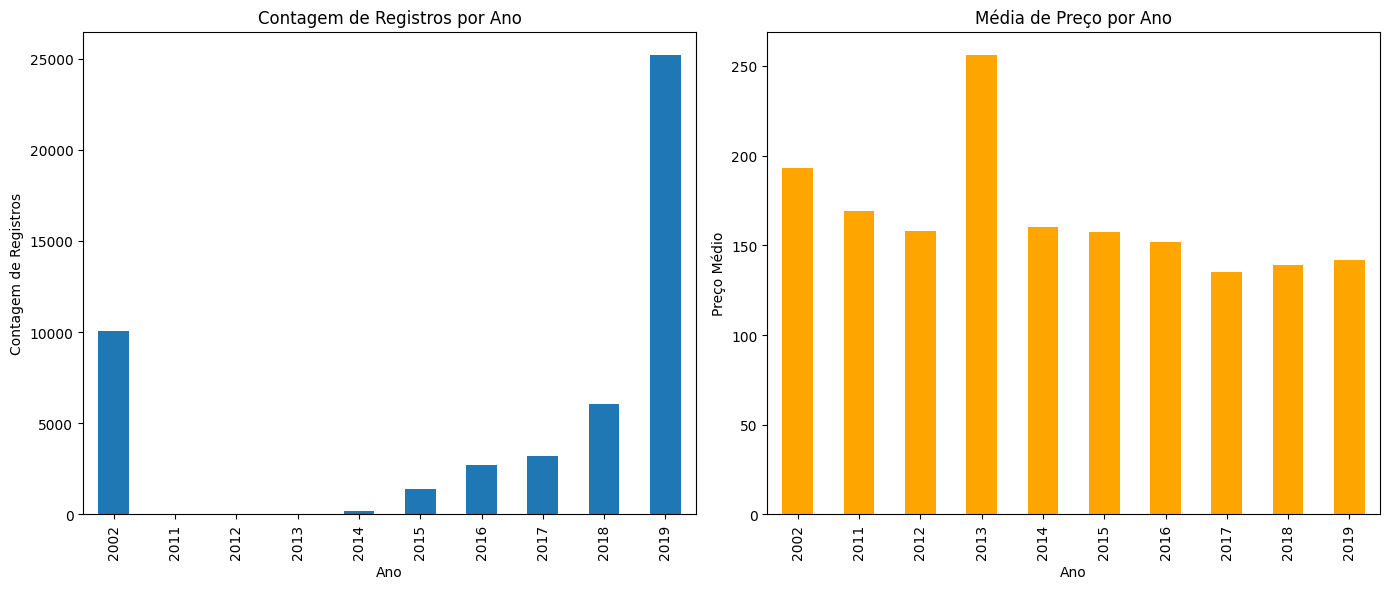

In [12]:
# 1. Extrair o ano da coluna 'ultima_review'
NY_df['ano_review'] = pd.to_datetime(NY_df['ultima_review']).dt.year

# 2. Contar registros por ano
registros_por_ano = NY_df['ano_review'].value_counts().sort_index()

# 3. Calcular a média de preços por ano
media_preco_por_ano = NY_df.groupby('ano_review')['price'].mean()

# Criando os plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # Contagem de registros por ano
registros_por_ano.plot(kind='bar')
plt.title('Contagem de Registros por Ano')
plt.xlabel('Ano')
plt.ylabel('Contagem de Registros')

plt.subplot(1, 2, 2)  # Média de preços por ano
media_preco_por_ano.plot(kind='bar', color='orange')
plt.title('Média de Preço por Ano')
plt.xlabel('Ano')
plt.ylabel('Preço Médio')

plt.tight_layout()
plt.show()

NY_df.drop(columns=['ano_review'], inplace=True)


A maioria dos registros de ultimo review é recente e os preços médios dos imóveis de registros antigos não é inferior, portanto, podemos manter os dados independe do ano do último registro.

# Preparando os dados

Vamos remover a coluna "nome" e adicionar no seu lugar colunas para informar a presença das palavras "furnished" e "luxury" e suas variações.

In [13]:
NY_df['nome'] = NY_df['nome'].astype(str)

def check_word_presence(word, name):
    return bool(re.search(word, name, re.IGNORECASE))

# Verificar se a palavra "furnished" está presente no nome
NY_df['is_furnished'] = NY_df['nome'].apply(lambda x: 'furnished' if check_word_presence('furn', x) else 'none')

# Verificar se a palavra "luxury" está presente no nome
NY_df['is_luxury'] = NY_df['nome'].apply(lambda x: 'luxury' if check_word_presence('lux', x) else 'none')

# Eliminar a coluna 'nome'
NY_df.drop(columns=['nome'], inplace=True)


In [14]:
def prepare_data(features, target, numeric_vars_normalize, numeric_vars_standardize):
    # Aplicando one-hot-encoding nas variáveis categóricas
    features_encoded = pd.get_dummies(features, columns=[col for col in features.columns if col not in numeric_vars_normalize + numeric_vars_standardize], dtype=float)
    
    # Separando as variáveis categóricas e numéricas
    features_numeric = features_encoded[numeric_vars_normalize + numeric_vars_standardize]
    features_categorical = features_encoded.drop(columns=numeric_vars_normalize + numeric_vars_standardize)
    
    # Dividindo os dados em conjunto de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.2, random_state=42)

    # Dividindo o conjunto de teste em conjunto de validação e teste
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    # Normalizando as variáveis numéricas
    scaler_normalize = MinMaxScaler(feature_range=(-1, 1))
    X_train_scaled_normalize = scaler_normalize.fit_transform(X_train[numeric_vars_normalize])
    X_val_scaled_normalize = scaler_normalize.transform(X_val[numeric_vars_normalize])
    X_test_scaled_normalize = scaler_normalize.transform(X_test[numeric_vars_normalize])
    
    # Padronizando as variáveis numéricas
    scaler_standardize = StandardScaler()
    X_train_scaled_standardize = scaler_standardize.fit_transform(X_train[numeric_vars_standardize])
    X_val_scaled_standardize = scaler_standardize.transform(X_val[numeric_vars_standardize])
    X_test_scaled_standardize = scaler_standardize.transform(X_test[numeric_vars_standardize])
    
    # Normalizando o vetor alvo (y)
    scaler_target = StandardScaler()
    y_train = scaler_target.fit_transform(np.array(y_train).reshape(-1, 1))
    y_val = scaler_target.transform(np.array(y_val).reshape(-1, 1))
    y_test = scaler_target.transform(np.array(y_test).reshape(-1, 1))
    
    # Substituindo os valores originais pelas versões normalizadas e padronizadas
    X_train[numeric_vars_normalize] = X_train_scaled_normalize
    X_val[numeric_vars_normalize] = X_val_scaled_normalize
    X_test[numeric_vars_normalize] = X_test_scaled_normalize
    
    X_train[numeric_vars_standardize] = X_train_scaled_standardize
    X_val[numeric_vars_standardize] = X_val_scaled_standardize
    X_test[numeric_vars_standardize] = X_test_scaled_standardize
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler_normalize, scaler_standardize, features_encoded, scaler_target


In [15]:
features = NY_df[['bairro_group', 'latitude', 'longitude', 'room_type', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365','is_furnished', 'is_luxury']]
target = NY_df['price']

# Determinando quais variáveis são numéricas e quais devem ser normalizadas e padronizadas.
numeric_vars_normalize = ['latitude', 'longitude']
numeric_vars_standardize = ['minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']

# Preparando os dados
X_train, X_val, X_test, y_train, y_val, y_test, scaler_normalize, scaler_standardize, features_encoded, scaler_target = prepare_data(features, target, numeric_vars_normalize, numeric_vars_standardize)

# Treinando os modelos

Iniciamos treinando um MLP da biblioteca do sklearn

In [16]:
def train_model_MLP(X_train, y_train, X_val, y_val, scaler_target):
    # Definindo e configurando o modelo MLP
    model = MLPRegressor(hidden_layer_sizes=(64, 32, 16),
                         activation='relu',
                         solver='adam',
                         alpha=0.0001,
                         batch_size='auto',
                         learning_rate='constant',
                         learning_rate_init=0.0003,
                         max_iter=600,
                         shuffle=True,
                         random_state=42,
                         verbose=False)
    
    # Treinando o modelo
    model.fit(X_train, y_train)
    
    # Fazendo previsões nos dados de validação
    y_val_pred = model.predict(X_val)
    
    # Desfazendo a padronização das previsões e dos labels
    y_val_pred_descaled = scaler_target.inverse_transform(y_val_pred.reshape(-1, 1)).ravel()
    y_val_descaled = scaler_target.inverse_transform(y_val.reshape(-1, 1)).ravel()
    
    # Calculando o MAE nos dados de validação
    val_mae = mean_absolute_error(y_val_descaled, y_val_pred_descaled)
    
    return val_mae, model

val_mae, model_1 = train_model_MLP(X_train, y_train, X_val, y_val, scaler_target)
print("MAE nos dados de validação:", val_mae)

MAE nos dados de validação: 72.64349491797644


Vamos implementar uma rede neural Perceptron multicamadas utilizando a biblioteca do tensorflow para ver se conseguimos melhorar o resultado.

In [17]:
def train_model_MLP(X_train, y_train, X_val, y_val):
    model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    #keras.layers.Dropout(0.1),
    keras.layers.Dense(1) 
    ])
    model.compile(optimizer='adam',
                  loss='mean_absolute_error')
    
    # Definindo um callback para salvar o modelo com menor MAE nos dados de validação
    checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', 
                                                           monitor='val_loss', 
                                                           mode='min', 
                                                           save_best_only=True)
    
    # Treinando o modelo
    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=0, callbacks=[checkpoint_callback])
    
    # Carregar o melhor modelo salvo
    best_model = keras.models.load_model('best_model.h5')

    # Fazendo previsões nos dados de validação
    y_val_pred = best_model.predict(X_val)
    
    # Desfazendo a padronização das previsões e dos labels
    y_val_pred_descaled = scaler_target.inverse_transform(y_val_pred)
    y_val_descaled = scaler_target.inverse_transform(y_val)
    
    # Calculando o MAE com dados despadronizados
    val_mae = mean_absolute_error(y_val_descaled, y_val_pred_descaled)
    
    return val_mae

# Treinando o modelo e obtendo os valores de MAE nos dados de validação
mae_val = train_model_MLP(X_train, y_train, X_val, y_val)
print("MAE nos dados de validação:", mae_val)


153/153 [==============================] - 0s 729us/step
MAE nos dados de validação: 59.687874327215056


O resultado melhorou bastante com nossa implementação no TensorFlow. Vamos tentar com o XGBoost.

In [18]:
# Definindo o modelo XGBoost
model = xgb.XGBRegressor(objective='reg:absoluteerror',
                         n_estimators=900,
                         max_depth=12,
                         learning_rate=0.01,
                         subsample=0.5,
                         colsample_bytree=0.5,
                         random_state=42)

# Treinando o modelo
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)],
          eval_metric='mae',  # Usando MAE como métrica de avaliação
          early_stopping_rounds=20,  # Parar o treinamento se não houver melhoria na métrica de validação após 20 rodadas
          verbose=False)

# Fazendo previsões nos dados de validação
y_val_pred = model.predict(X_val)

# Desfazendo a padronização das previsões e dos labels
y_val_pred_descaled = scaler_target.inverse_transform(y_val_pred.reshape(-1, 1)).ravel()
y_val_descaled = scaler_target.inverse_transform(y_val.reshape(-1, 1)).ravel()

# Calculando o MAE nos dados de validação despadronizados
val_mae = mean_absolute_error(y_val_descaled, y_val_pred_descaled)

print(f'MAE nos dados de validação: {val_mae:.4f}')

MAE nos dados de validação: 58.4199


O XGBoost apresentou um resultado um pouco melhor no conjunto de validação. Vamos ficar com esse modelo por ser mais simples de implementar do que a MLP do TensorFlow. Portanto, testamos um pouco com os hiperparâmetros para tentar melhorar o resultado no conjunto de validação e então selecionamos o melhor modelo e calculamos os resultados no conjunto de teste.

In [19]:
# Fazendo previsões no conjunto de teste
predictions = model.predict(X_test)

# Redimensionando as previsões para serem 2D
predictions = predictions.reshape(-1, 1)


# Desfazendo a padronização das previsões
predictions = scaler_target.inverse_transform(predictions)

y_test_original = scaler_target.inverse_transform(y_test)

# Calculando o MAE nos dados de teste
mae = mean_absolute_error(y_test_original, predictions)
print("MAE nos dados de teste:", mae)

MAE nos dados de teste: 53.767103484218104


In [20]:
# Visualizando os primeiros 30 valores reais e previstos
for i in range(20):
    print(f"Real: {y_test_original[i]}, Previsto: {predictions[i][0]:.2f}")

Real: [120.], Previsto: 126.19
Real: [180.], Previsto: 178.85
Real: [120.], Previsto: 138.98
Real: [125.], Previsto: 99.75
Real: [60.], Previsto: 65.22
Real: [85.], Previsto: 123.31
Real: [34.], Previsto: 51.35
Real: [75.], Previsto: 108.92
Real: [67.], Previsto: 70.12
Real: [194.], Previsto: 172.49
Real: [100.], Previsto: 118.23
Real: [64.], Previsto: 79.92
Real: [500.], Previsto: 190.63
Real: [250.], Previsto: 99.89
Real: [55.], Previsto: 86.96
Real: [295.], Previsto: 154.23
Real: [60.], Previsto: 74.48
Real: [250.], Previsto: 160.14
Real: [600.], Previsto: 228.60
Real: [50.], Previsto: 61.47


Os resultados parecem bons. Vamos salvar o modelo e os scalers

In [21]:
saved_objects = {
    'scaler_normalize': scaler_normalize,
    'scaler_standardize': scaler_standardize,
    'scaler_target': scaler_target,
    'model': model
}

# Salvando o dicionário em um arquivo pkl
joblib.dump(saved_objects, 'modelo_e_scalers.pkl')

print(f'Modelo e scalers foram salvos')

Modelo e scalers foram salvos









# >>>>>>>> Testando o modelo em novos anúncios <<<<<<<<








In [22]:
import joblib
import pandas as pd
import re

# Carregando o arquivo pkl
loaded_objects = joblib.load('modelo_e_scalers.pkl')

# Recuperando os objetos do dicionário carregado
scaler_normalize = loaded_objects['scaler_normalize']
scaler_standardize = loaded_objects['scaler_standardize']
scaler_target = loaded_objects['scaler_target']
model = loaded_objects['model']

print("Modelo e scalers foram carregados com sucesso.")

Modelo e scalers foram carregados com sucesso.


In [23]:
imovel = pd.DataFrame({
    'id': [2595],
    'nome': ['Skylit Midtown Castle'],
    'host_id': [2845],
    'host_name': ['Jennifer'],
    'bairro_group': ['Manhattan'],
    'bairro': ['Midtown'],
    'latitude': [40.75362],
    'longitude': [-73.98377],
    'room_type': ['Entire home/apt'],
    'price': [225],
    'minimo_noites': [1],
    'numero_de_reviews': [45],
    'ultima_review': ['2019-05-21'],
    'reviews_por_mes': [0.38],
    'calculado_host_listings_count': [2],
    'disponibilidade_365': [355]
})

In [24]:
# Função para verificar a presença de uma palavra em uma string
def check_word_presence(word, name):
    return bool(re.search(word, name, re.IGNORECASE))

# Função para preparar os dados e fazer a predição do preço
def predict_price(model, scaler_target, scaler_normalize, scaler_standardize, imovel):
    # Criar colunas de is_furnished e is_luxury
    imovel['is_furnished'] = imovel['nome'].apply(lambda x: 'furnished' if check_word_presence('furn', x) else 'none')
    imovel['is_luxury'] = imovel['nome'].apply(lambda x: 'luxury' if check_word_presence('lux', x) else 'none')
    
    # Eliminar a coluna 'nome'
    imovel.drop(columns=['nome'], inplace=True)
    
    # Selecionar as características e o alvo
    features = imovel[['bairro_group', 'latitude', 'longitude', 'room_type', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365','is_furnished', 'is_luxury']]
    
    # Aplicar one-hot encoding nas variáveis categóricas
    features_encoded = pd.get_dummies(features, columns=['bairro_group', 'room_type', 'is_furnished', 'is_luxury'], dtype=float)
    
    # Normalizar as variáveis numéricas
    features_encoded[['latitude', 'longitude']] = scaler_normalize.transform(features_encoded[['latitude', 'longitude']])
    
    # Padronizar as variáveis numéricas
    features_encoded[['minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']] = scaler_standardize.transform(features_encoded[['minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']])
    
    # Preencher as colunas dummy ausentes com 0
    dummy_columns = ['bairro_group_Bronx', 'bairro_group_Brooklyn', 'bairro_group_Manhattan', 'bairro_group_Queens', 'bairro_group_Staten Island',
                     'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room',
                     'is_furnished_furnished', 'is_furnished_none',
                     'is_luxury_luxury', 'is_luxury_none']
    for col in dummy_columns:
        if col not in features_encoded.columns:
            features_encoded[col] = 0.0
            
    # garantindo a ordem correta        
    features_encoded = features_encoded[['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
                               'calculado_host_listings_count', 'disponibilidade_365', 'bairro_group_Bronx', 
                               'bairro_group_Brooklyn', 'bairro_group_Manhattan', 'bairro_group_Queens', 
                               'bairro_group_Staten Island', 'room_type_Entire home/apt', 'room_type_Private room', 
                               'room_type_Shared room', 'is_furnished_furnished', 'is_furnished_none', 
                               'is_luxury_luxury', 'is_luxury_none']]
    
    preco_pred = model.predict(features_encoded)
    
    # Desfazer a padronização do preço predito
    preco_pred_descaled = scaler_target.inverse_transform(preco_pred.reshape(-1, 1))
    
    return preco_pred_descaled[0][0]

In [25]:
# Fazer a predição utilizando a função 

preco_predito = predict_price(model=model, 
                              scaler_target=scaler_target, 
                              scaler_normalize=scaler_normalize, 
                              scaler_standardize=scaler_standardize, 
                              imovel=imovel)

print("Preço predito:", preco_predito)


Preço predito: 233.86082
